# Output versus pressure curve from 2020-02-24

In [2]:
import numpy as np
import pandas as pd
import pymysql
import sqlalchemy as sql
import matplotlib.pyplot as plt
import matplotlib.dates as md
import seaborn as sns
sns.set()
import getopt
import sys
import datetime
from scipy.interpolate import interp1d
from NGDataObject import NGDataObject
from scipy.optimize import curve_fit
from scipy import optimize

#*******************************
# CONSTANTS
#*******************************
# connection to database
CREDENTIALS_FILE = '/Users/hkromer/02_PhD/01.github/dash_NG/credentials.pw'
DB = "NG_twofast_DB" # name of the database
HOST = "twofast-RPi3-0"  # database host

# LOOKUP TABLES
LUT_PRESSURE_ION_SOURCE = "/Users/hkromer/02_PhD/01.github/phd/01_neutron_generator_contol/LUT_pressure_ion_source.txt"

In [3]:
# reference detectors
# dose
# HV
DAY = "2020-02-24"
path = '/Users/hkromer/02_PhD/02_Data/13.new_chamber/2020-02-24.Output_vs_pressure/'
# read password and user to connect to database
credentials = pd.read_csv(CREDENTIALS_FILE, header=0)
user = credentials['username'].values[0]
pw = credentials['password'].values[0]



# #*******************************
# # GET DATA
# #*******************************

# # connect to DB
# con = NGDataObject(host = HOST, database=DB, user=user, password=pw)

# # get dose
# query = "SELECT * FROM data_dose WHERE DATE(time) = '%(t)s'" % {"t": DAY}
# data_dose = con.get_from_database(query=query)

# # get HV
# query = "SELECT * FROM data_HV WHERE DATE(time) = '%(t)s'" % {"t": DAY}
# data_hv = con.get_from_database(query=query)
# data_hv['HV_current_x100'] = data_hv['HV_current']*100.0

# # get pressure
# query = "SELECT * FROM data_pressure WHERE DATE(time) = '%(t)s'" % {"t": DAY}
# data_pressure = con.get_from_database(query=query)

# # get reference detectors
# query = "SELECT * FROM data_referenceDetectors WHERE DATE(time) > '2020-02-03 20:00:00'" 
# data_reference_full = con.get_from_database(query=query)

# # get microwave power
# query = "SELECT * FROM microwave_generator_power WHERE DATE(time) = '%(t)s'" % {"t": DAY}
# data_microwave_power_full = con.get_from_database(query=query)

# # get microwave frequency
# query = "SELECT * FROM microwave_generator_frequency WHERE DATE(time) = '%(t)s'" % {"t": DAY}
# data_microwave_frequency_full = con.get_from_database(query=query)

# # save to file
# data_reference_full['sum_counts'] = data_reference_full['counts_D1'] + data_reference_full['counts_D2'] + data_reference_full['counts_D3'] + data_reference_full['counts_D4'] 




In [4]:
path = '/Users/hkromer/02_PhD/02_Data/13.new_chamber/2020-02-24.Output_vs_pressure/'
DAY = "2020-02-24"

# data_dose.to_csv(f'{path}/{DAY}_dose.csv')
# data_hv.to_csv(f'{path}/{DAY}_hv.csv')
# data_pressure.to_csv(f'{path}/{DAY}_pressure.csv')
# # data_reference_full.to_csv(f'{path}/2020-02-07_reference_detectors.csv')
# data_microwave_power_full.to_csv(f'{path}/{DAY}_microwave_power.csv')
# data_microwave_frequency_full.to_csv(f'{path}/{DAY}_microwave_frequency.csv')

In [5]:
path = '/Users/hkromer/02_PhD/02_Data/13.new_chamber/2020-02-24.Output_vs_pressure/'
DAY = "2020-02-24"

data_dose = pd.read_csv(f'{path}/{DAY}_dose.csv', index_col=0)
data_dose.index = pd.to_datetime(data_dose.index)

data_hv = pd.read_csv(f'{path}/{DAY}_hv.csv', index_col=0)
data_hv.index = pd.to_datetime(data_hv.index)

data_pressure = pd.read_csv(f'{path}/{DAY}_pressure.csv', index_col=0)
data_pressure.index = pd.to_datetime(data_pressure.index)

# data_reference_full.to_csv(f'{path}/2020-02-07_reference_detectors.csv')
data_microwave_power_full = pd.read_csv(f'{path}/{DAY}_microwave_power.csv', index_col=0)
data_microwave_power_full.index = pd.to_datetime(data_microwave_power_full.index)

data_microwave_frequency_full = pd.read_csv(f'{path}/{DAY}_microwave_frequency.csv', index_col=0)
data_microwave_frequency_full.index = pd.to_datetime(data_microwave_frequency_full.index)



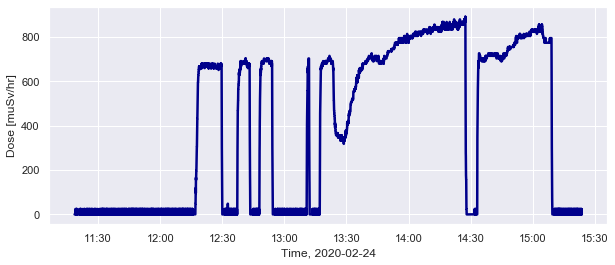

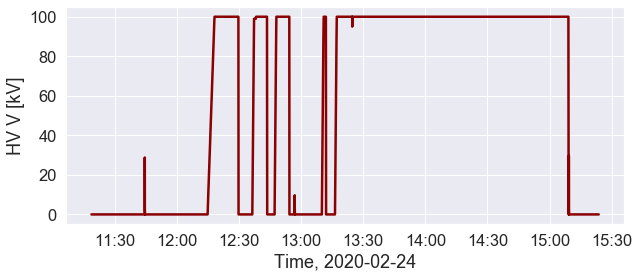

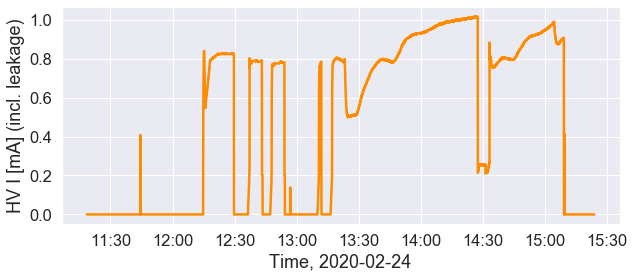

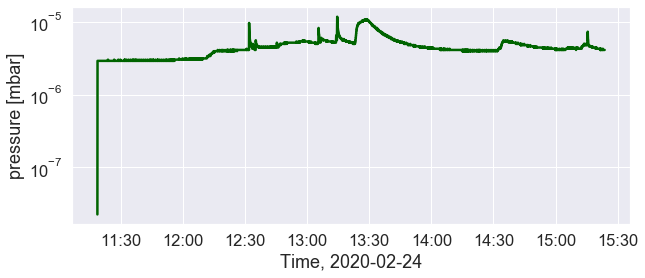

In [6]:
fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data_dose.index, y='dose_corrected', data=data_dose, ax=ax, color='darkblue')

ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
ax.set_ylabel('Dose [muSv/hr]')
ax.set_xlabel(f'Time, {DAY}')
plt.show()

fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data_hv.index, y='HV_voltage', data=data_hv, ax=ax, color='darkred')

ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
ax.set_ylabel('HV V [kV]')
ax.set_xlabel(f'Time, {DAY}')
plt.show()

fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data_hv.index, y='HV_current', data=data_hv, ax=ax, color='darkorange')

ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
ax.set_ylabel('HV I [mA] (incl. leakage)')
ax.set_xlabel(f'Time, {DAY}')
plt.show()


fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data_pressure.index, y='pressure_IS_corrected', data=data_pressure, ax=ax, color='darkgreen')

ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
ax.set_ylabel('pressure [mbar]')
ax.set_xlabel(f'Time, {DAY}')
ax.set_yscale('log')
plt.show()


## Select time more closely when BROOKS was closed

- closed 13:28 Uhr

In [7]:
time_start = f'{DAY} 13:28:00'
time_end = f'{DAY} 14:27:10'

df_hv = data_hv.loc[time_start:time_end]
df_pressure = data_pressure.loc[time_start:time_end]
df_dose = data_dose.loc[time_start:time_end]
df_freq = data_microwave_frequency_full.loc[time_start:time_end]
df_power = data_microwave_power_full.loc[time_start:time_end]


# fig, ax = plt.subplots(figsize=(10,4))
# sns.set()
# sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
# sns.lineplot(x=df_dose.index, y='dose_corrected', data=df_dose, ax=ax, color='darkblue')

# ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
# ax.set_ylabel('Dose [muSv/hr]')
# ax.set_xlabel(f'Time, {DAY}')
# plt.show()

# fig, ax = plt.subplots(figsize=(10,4))
# sns.set()
# sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
# sns.lineplot(x=df_hv.index, y='HV_voltage', data=df_hv, ax=ax, color='darkred')

# ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
# ax.set_ylabel('HV V [kV]')
# ax.set_xlabel(f'Time, {DAY}')
# plt.show()

# fig, ax = plt.subplots(figsize=(10,4))
# sns.set()
# sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
# sns.lineplot(x=df_hv.index, y='HV_current', data=df_hv, ax=ax, color='darkorange')

# ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
# ax.set_ylabel('HV I [mA] (incl. leakage)')
# ax.set_xlabel(f'Time, {DAY}')
# plt.show()




# fig, ax = plt.subplots(figsize=(10,4))
# sns.set()
# sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
# sns.lineplot(x=df_pressure.index, y='pressure_IS_corrected', data=df_pressure, ax=ax, color='darkgreen')

# ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
# ax.set_ylabel('pressure [mbar]')
# ax.set_xlabel(f'Time, {DAY}')
# ax.set_yscale('log')
# plt.show()



# fig, ax = plt.subplots(figsize=(10,4))
# sns.set()
# sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
# sns.lineplot(x=df_freq.index, y='frequency', data=df_freq, ax=ax, color='pink')

# ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
# ax.set_ylabel('Frequency [0.1 MHz]')
# ax.set_xlabel(f'Time, {DAY}')
# plt.show()


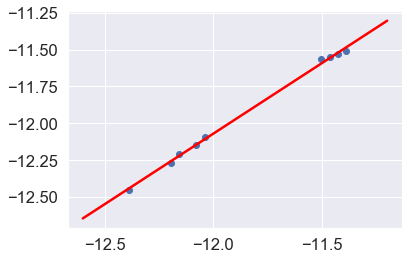

(0.9978181028115057, 0.9582695068380577, -0.5718235412479196)

In [8]:
# correlation between pressure read on display and pressure recorded in python
from sklearn.linear_model import LinearRegression

p_display = np.asarray([9.5e-6, 9.6e-6, 9.8e-6, 1.0e-5, 5.6e-6, 5.3e-6, 5.0e-6, 4.7e-6, 3.9e-6], float)
p_py = np.asarray([1.01e-5, 1.05e-5, 1.09e-5, 1.13e-5, 5.91e-6, 5.68e-6, 5.26e-6, 5.06e-6, 4.18e-6], float)

# convert into linear space
X = np.log(p_py).reshape(-1,1)
y = np.log(p_display).reshape(-1,1)

reg = LinearRegression().fit(X, y)
m = reg.coef_[0][0]
c = reg.intercept_[0]
y_fit = lambda x: x*m+c
plt.scatter(np.log(p_py), np.log(p_display))
x = np.linspace(-12.6, -11.2, 100)
plt.plot(x, y_fit(x), color='red')
plt.show()
reg.score(X, y), m, c

In [9]:
def correct_display_pressure(row_pressure, y_fit):
    # conver to log
    p = np.log(row_pressure)
    # use correction
    p_out = y_fit(p)
    # transform back
    p_out = np.exp(p_out)
    
    return p_out
df_pressure.loc[:, 'pressure_IS_display_corr'] = df_pressure.loc[:, 'pressure_IS_corrected'].apply(lambda x: correct_display_pressure(x, y_fit))

/Users/hkromer/anaconda3/envs/py3.7/lib/python3.8/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/hkromer/anaconda3/envs/py3.7/lib/python3.8/site-packages/pandas/core/indexing.py:964: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


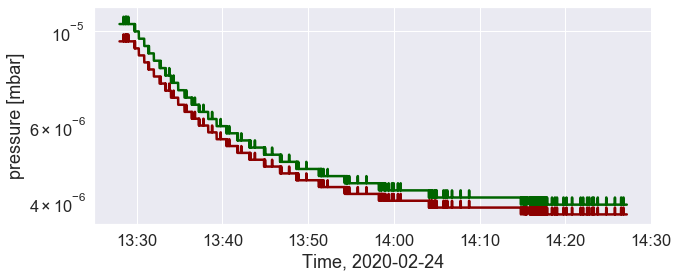

In [10]:
fig, ax = plt.subplots(figsize=(10,4))

sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=df_pressure.index, y='pressure_IS_corrected', data=df_pressure, ax=ax, color='darkgreen')
sns.lineplot(x=df_pressure.index, y='pressure_IS_display_corr', data=df_pressure, ax=ax, color='darkred')

# plt.xlim(f'{DAY} 13:28:00', f'{DAY} 13:35:00')
ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
ax.set_ylabel('pressure [mbar]')
ax.set_xlabel(f'Time, {DAY}')
ax.set_yscale('log')
# plt.ylim(9.4e-6, 9.1e-6)
plt.show()

### Resample values to put into one dataframe

In [11]:
def resample_30_seconds(df, cols, range_start, range_end):
    """
    Takes the a grouped df (grouped by day) and resamples the columns cols in 10s
    OUTPUT:
        - dataframe
    """

    d = {}

    s = pd.date_range(start=range_start, end=range_end, freq='10S')
    df_out = pd.DataFrame(pd.Series(s, name='time')).set_index('time')
    for col in cols:
        d[col] = df[col].resample('10S').mean()

    this_d = pd.DataFrame(d)

    df_out = df_out.merge(this_d, left_on=df_out.index, right_on=this_d.index, how='outer')
    df_out = df_out.set_index('key_0')
    df_out.index.name ='time'    
    
    return df_out

In [12]:
df_power.head()

,FP,RP,power_setpoint,id
time,,,,
2020-02-24 13:28:00.050118,200.0,12.0,200.0,499497
2020-02-24 13:28:00.343074,200.0,12.0,200.0,499498
2020-02-24 13:28:00.636238,200.0,12.0,200.0,499499
2020-02-24 13:28:00.928690,200.0,12.0,200.0,499500
2020-02-24 13:28:01.222688,200.0,12.0,200.0,499501


In [13]:


# current resampled in 30s blocks
data_I = resample_30_seconds(df_hv, ['HV_current', 'HV_voltage'], time_start, time_end)
# pressure resampled in 30s blocks
data_p = resample_30_seconds(df_pressure, ['pressure_IS_display_corr'], time_start, time_end)
data_freq = resample_30_seconds(df_freq, ['frequency'], time_start, time_end)
data_power = resample_30_seconds(df_power, ['FP', 'RP'], time_start, time_end)

# fig, ax = plt.subplots(figsize=(10,4))
# sns.set()
# sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
# sns.lineplot(x=df_hv.index, y='HV_current', data=df_hv, ax=ax, color='darkorange')
# sns.lineplot(x=data_I.index, y='HV_current', data=data_I, ax=ax, color='darkred')

# ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
# ax.set_ylabel('HV I [mA] (incl. leakage)')
# ax.set_xlabel(f'Time, {DAY}')
# plt.show()

# fig, ax = plt.subplots(figsize=(10,4))

# sns.set()
# sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
# sns.lineplot(x=df_pressure.index, y='pressure_IS_display_corr', data=df_pressure, ax=ax, color='darkorange')
# sns.lineplot(x=data_p.index, y='pressure_IS_display_corr', data=data_p, ax=ax, color='darkred')

# # plt.xlim(f'{DAY} 13:28:00', f'{DAY} 13:35:00')
# ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
# ax.set_ylabel('pressure [mbar]')
# ax.set_xlabel(f'Time, {DAY}')
# ax.set_yscale('log')
# # plt.ylim(9.4e-6, 9.1e-6)
# plt.show()

In [14]:
data = pd.merge(data_I, data_p, left_index=True, right_index=True, how='outer')
data = pd.merge(data, data_freq, left_index=True, right_index=True, how='outer')
data = pd.merge(data, data_power, left_index=True, right_index=True, how='outer')
data.head()

,HV_current,HV_voltage,pressure_IS_display_corr,frequency,FP,RP
time,,,,,,
2020-02-24 13:28:00,0.51036,100.0,0.000009,24485.0,200.0,12.0
2020-02-24 13:28:10,0.51080,100.0,0.000009,24485.0,200.0,12.0
2020-02-24 13:28:20,0.51080,100.0,0.000010,24485.0,200.0,12.0
2020-02-24 13:28:30,0.51124,100.0,0.000009,24485.0,200.0,12.0
2020-02-24 13:28:40,0.51080,100.0,0.000010,24485.0,200.0,12.0


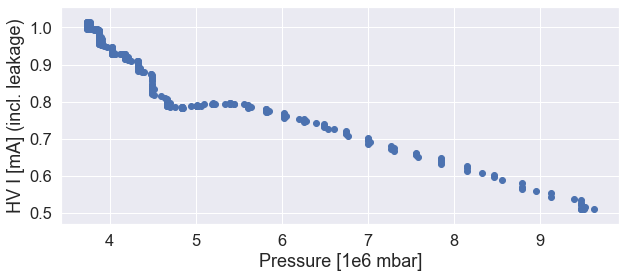

In [15]:
fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
I = data['HV_current'].values # current in mA
p = data['pressure_IS_display_corr'].values * 1e6 # pressure in mbar

plt.scatter(p, I)

# ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
ax.set_ylabel('HV I [mA] (incl. leakage)')
ax.set_xlabel(f'Pressure [1e6 mbar]')
# plt.xlim(0, 1e-5)
plt.show()

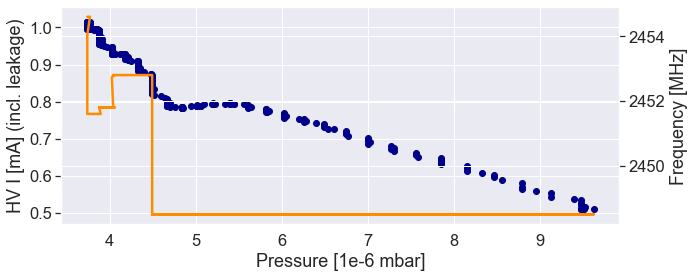

In [16]:
fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
I = data['HV_current'].values # current in mA
p = data['pressure_IS_display_corr'].values * 1e6 # pressure in mbar
freq = data['frequency'].values * 0.1 # frequency in MHz

plt.scatter(p, I, color='darkblue')
ax2 = ax.twinx()
ax2.plot(p, freq, color='darkorange')
# ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
ax.set_ylabel('HV I [mA] (incl. leakage)')
ax2.set_ylabel('Frequency [MHz]')
ax.set_xlabel(f'Pressure [1e-6 mbar]')
# plt.xlim(0, 1e-5)
plt.show()

In [17]:
data.head()

,HV_current,HV_voltage,pressure_IS_display_corr,frequency,FP,RP
time,,,,,,
2020-02-24 13:28:00,0.51036,100.0,0.000009,24485.0,200.0,12.0
2020-02-24 13:28:10,0.51080,100.0,0.000009,24485.0,200.0,12.0
2020-02-24 13:28:20,0.51080,100.0,0.000010,24485.0,200.0,12.0
2020-02-24 13:28:30,0.51124,100.0,0.000009,24485.0,200.0,12.0
2020-02-24 13:28:40,0.51080,100.0,0.000010,24485.0,200.0,12.0


In [18]:
data['RP'].describe()

count    356.000000
mean      13.698059
std        5.892749
min        5.000000
25%        8.000000
50%       13.014706
75%       20.000000
max       22.000000
Name: RP, dtype: float64

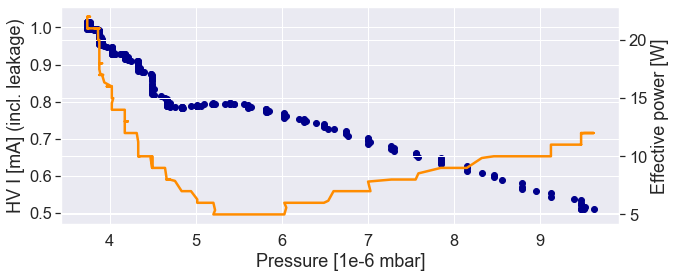

In [19]:
fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
I = data['HV_current'].values # current in mA
p = data['pressure_IS_display_corr'].values * 1e6 # pressure in mbar
power = (data['RP'].values)  # power in W

plt.scatter(p, I, color='darkblue')
ax2 = ax.twinx()
ax2.plot(p, power, color='darkorange')
# ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
ax.set_ylabel('HV I [mA] (incl. leakage)')
ax2.set_ylabel('Effective power [W]')
ax.set_xlabel(f'Pressure [1e-6 mbar]')
# plt.xlim(0, 1e-5)
plt.show()

#### Correct ion beam current for leakage current

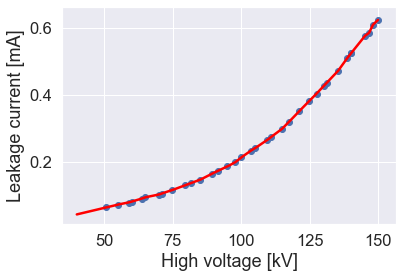

In [20]:
fname = '/Users/hkromer/02_PhD/02_Data/13.new_chamber/2020-02-03.NeutronOutputVSBeamPower/2020-02-03_LEAKGE_CURRENT_LUT.csv'
data_leak = pd.read_csv(fname, index_col=0)
# interpolate
X = data_leak['HV_voltage'].values.astype(np.float64)
Y = data_leak['HV_current'].values.astype(np.float64)
interp_leak = interp1d(X, Y, fill_value='extrapolate')

x = np.linspace(40, 160, 1000, endpoint=True)
plt.plot(x, interp_leak(x), color='red')
plt.scatter(data_leak['HV_voltage'], data_leak['HV_current'])
plt.xlabel('High voltage [kV]')
plt.ylabel('Leakage current [mA]')
plt.show()

#### Correct current

In [21]:
data['HV_current_corrected'] = data['HV_current'] - interp_leak(data['HV_voltage'].values)
data.head()

,HV_current,HV_voltage,pressure_IS_display_corr,frequency,FP,RP,HV_current_corrected
time,,,,,,,
2020-02-24 13:28:00,0.51036,100.0,0.000009,24485.0,200.0,12.0,0.296525
2020-02-24 13:28:10,0.51080,100.0,0.000009,24485.0,200.0,12.0,0.296965
2020-02-24 13:28:20,0.51080,100.0,0.000010,24485.0,200.0,12.0,0.296965
2020-02-24 13:28:30,0.51124,100.0,0.000009,24485.0,200.0,12.0,0.297405
2020-02-24 13:28:40,0.51080,100.0,0.000010,24485.0,200.0,12.0,0.296965


### Thesis plot

In [22]:
from matplotlib.ticker import AutoMinorLocator
sns.reset_orig()
import os, matplotlib
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2018/bin/x86_64-darwin'
plt.rc('text', usetex=True)
plt.rc('font', weight='bold')
from matplotlib.ticker import AutoMinorLocator
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Arial'
matplotlib.rcParams['mathtext.it'] = 'Arial:italic'
matplotlib.rcParams['mathtext.bf'] = 'Arial:bold'
matplotlib.rcParams['mathtext.tt'] = 'Arial'
matplotlib.rcParams['mathtext.cal'] = 'Arial'
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']


In [23]:
FOLDER = '/Users/hkromer/polybox/Thesis/Chapters/FurtherNeutronGeneratorUpgrades/Figures/Target_current_vs_pressure/'
FIGNAME = 'Target_current_vs_pressure'

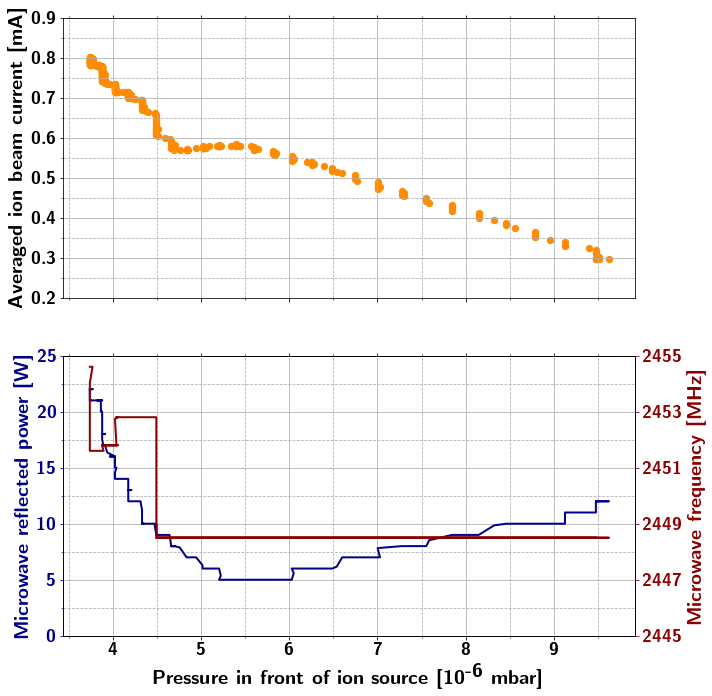

In [24]:
fig, axs = plt.subplots(2, 1, figsize=(10,10), sharex=True, sharey=False)
fs = 20
ax1 = axs[0]
ax2 = axs[1]

# Upper plot: current vs pressure
I = data['HV_current_corrected'].values # current in mA
p = data['pressure_IS_display_corr'].values * 1e6 # pressure in mbar

ax1.scatter(p, I, color='darkorange', s=40)
ax1.set_ylabel(r'\textbf{Averaged ion beam current [mA]}', fontsize=fs)

# Lower plot: Microwave power and frequency vs pressure
power = (data['RP'].values)  # power in W
freq = data['frequency'].values * 0.1 # frequency in MHz
ax2.plot(p, power, color='darkblue', linewidth=2.0)
ax2.set_xlabel(r'\textbf{Pressure in front of ion source [10$^{\textbf{-6}}$ mbar]}', fontsize=fs)
ax2.set_ylabel(r'\textbf{Microwave reflected power [W]}', fontsize=fs, color='darkblue')

ax2_2 = ax2.twinx()
ax2_2.plot(p, freq, color='darkred', linewidth=2.0)
ax2_2.set_ylabel(r'\textbf{Microwave frequency [MHz]}', fontsize=fs, color='darkred')
ax2_2.tick_params(axis='x',          # changes apply to the x-axis
               which='both',      # both major and minor ticks are affected
               bottom='off',      # ticks along the bottom edge are off
               top='off',         # ticks along the top edge are off
               labelbottom='off',  # labels along the bottom edge are off)
               colors='black', 
               labelsize=fs-2
              )
ax2_2.tick_params(axis='y',          # changes apply to the x-axis
               which='both',      # both major and minor ticks are affected
               bottom='off',      # ticks along the bottom edge are off
               top='off',         # ticks along the top edge are off
               labelbottom='off',  # labels along the bottom edge are off)
               colors='darkred', 
               labelsize=fs-2
              )
for ax in axs:
    minor_locator = AutoMinorLocator(2)
    ax.xaxis.set_minor_locator(minor_locator)
    # minor ticks y
    minor_locator = AutoMinorLocator(2)
    ax.yaxis.set_minor_locator(minor_locator)
    ax.grid(b=True, which='major', linestyle='-')#, color='gray')
    ax.grid(b=True, which='minor', linestyle='--')#, color='gray')

    ax.tick_params(axis='x',          # changes apply to the x-axis
                   which='both',      # both major and minor ticks are affected
                   bottom='off',      # ticks along the bottom edge are off
                   top='off',         # ticks along the top edge are off
                   labelbottom='off',  # labels along the bottom edge are off)
                   colors='black', 
                   labelsize=fs-2
                  )
    ax.tick_params(axis='y',          # changes apply to the x-axis
                   which='both',      # both major and minor ticks are affected
                   bottom='off',      # ticks along the bottom edge are off
                   top='off',         # ticks along the top edge are off
                   labelbottom='off',  # labels along the bottom edge are off)
                   colors='black', 
                   labelsize=fs-2
                  )

ax2.tick_params(axis='x',          # changes apply to the x-axis
               which='both',      # both major and minor ticks are affected
               bottom='off',      # ticks along the bottom edge are off
               top='off',         # ticks along the top edge are off
               labelbottom='off',  # labels along the bottom edge are off)
               colors='black', 
               labelsize=fs-2
              )
ax2.tick_params(axis='y',          # changes apply to the x-axis
               which='both',      # both major and minor ticks are affected
               bottom='off',      # ticks along the bottom edge are off
               top='off',         # ticks along the top edge are off
               labelbottom='off',  # labels along the bottom edge are off)
               colors='darkblue', 
               labelsize=fs-2
              )
# Hide x labels and tick labels for all but bottom plot.
for ax in axs:
    ax.label_outer()
    
ax2.set_ylim(0, 25)
ax2_2.set_ylim(2445, 2455)
ax2_2.set_yticks(np.arange(2445, 2455+2, 2))
ax1.set_ylim(0.2, 0.9)

plt.tight_layout()    
plt.savefig(f"{FOLDER}/{FIGNAME}.pdf")
plt.show()